##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer Learning Using Pretrained ConvNets

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this tutorial we will discuss how to classify cats vs dogs images by using transfer learning from a pre-trained network. This will allows us to get higher accuracies than we saw by training our network from scratch.

A **pre-trained model** is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. We can either use the pretrained model as it is or transfer learning using the pretrained ConvNets. The intuition behind **transfer learning** is that if this model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can leverage these learned feature maps without having to train a large model on a large dataset by using these models as the basis of our own model specific to our task. There are 2 scenarios of transfer learning using a pretrained model:

1. **Feature Extraction** - use the representations learned by a previous network to extract meaningful features from new samples. We simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that we can repurpose the feature maps learned previously for our dataset. **Do we use the entire pretrained model or just the convolutional base?** - We use the feature extraction portion of these pretrained ConvNets (convolutional base) since they are likely to be generic features and learned concepts over a picture. However, the classification part of the pretrained model is often specific to original classification task, and subsequently specific to the set of classes on which the model was trained.
2. **Fine-Tuning** - unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added classifier layers as well as the last layers of the frozen model. This allows us to "fine tune" the higher order feature representations in addition to our final classifier in order to make them more relevant for the specific task involved.

**We will follow the general machine learning workflow:**

1. Examine and understand data
2. Build an input pipeline - using Keras ImageDataGenerator as we did in the image classification tutorial
3. Compose our model
    * Load in our pretrained model (and pretrained weights)
    * Stack our classification layers on top
4. Train our model
5. Evaluate model

We will see an example of using the pre-trained ConvNet as the feature extraction and then fine-tune to train the last few layers of the base model.

**Audience:** This post is geared towards beginners with some Keras API and ML background. To get the most out of this post, you should have some basic ML background, know what CNNs are, and be familiar with the Keras Sequential API.

**Time Estimated**: 30 minutes

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.14.0


## Data preprocessing

### Download data - cats_and_dogs_filtered.zip
We will download a filtered version of Kaggle's [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset. Then store the downloaded zip file to the "/tmp/" directory.

In [4]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

### Prepare training and validation cats and dogs datasets
Create the training and validation directories for cats datasets and dog datasets.

In [5]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


### Create Image Data Generator with Image Augmentation

We will use `ImageDataGenerator` to rescale the images.

To create the train generator, specify where the train dataset directory, image size, batch size and binary classification mode.

The validation generator is created the same way.

In [6]:
image_size = 160 # All images will be resized to 160x160
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Create the base model from the pre-trained ConvNets
We will create the base model from the **ResNet50** model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. This is a powerful model. Let's see what the features that it has learned can do for our cat vs. dog problem.

First, we need to pick which intermediate layer of ResNet50 we will use for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an ResNet50 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, we load **a network that doesn't include the classification layers at the top**, which is ideal for feature extraction.

In [7]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model ResNet50
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 28s 0us/step


## Feature extraction
We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting `layer.trainable = False`), we prevent the weights in these layers from being updated during training.

In [8]:
base_model.trainable = False

In [9]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 80, 80, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

#### Add a classification head

Now let's add a few layers on top of the base model:

In [10]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

W0825 02:56:25.892300 140166823933696 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Compile the model

You must compile the model before training it.

In [11]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

W0825 02:56:27.432062 140166823933696 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


These 1.2K trainable parameters are divided among 2 TensorFlow `Variable` objects, the weights and biases of the two dense layers:

In [13]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, we are able to get ~94% accuracy.

If you have more time, train it to convergence (50 epochs, ~96% accuracy)


In [14]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 76s 1s/step - loss: 0.6371 - acc: 0.6535 - val_loss: 0.6920 - val_acc: 0.4688
Epoch 2/10
62/62 [==============================] - 75s 1s/step - loss: 0.4702 - acc: 0.7944 - val_loss: 0.6894 - val_acc: 0.5716
Epoch 3/10
62/62 [==============================] - 74s 1s/step - loss: 0.3720 - acc: 0.8566 - val_loss: 0.6906 - val_acc: 0.5111
Epoch 4/10
62/62 [==============================] - 77s 1s/step - loss: 0.3018 - acc: 0.8968 - val_loss: 0.6918 - val_acc: 0.5040
Epoch 5/10
62/62 [==============================] - 76s 1s/step - loss: 0.2730 - acc: 0.8994 - val_loss: 0.6945 - val_acc: 0.5030
Epoch 6/10
62/62 [==============================] - 76s 1s/step - loss: 0.2401 - acc: 0.9167 - val_loss: 0.6968 - val_acc: 0.5030
Epoch 7/10
62/62 [==============================] - 76s 1s/step - loss: 0.2194 - acc: 0.9217 - val_loss: 0.6965 - val_acc: 0.5030
Epoch 8/10
62/62 [==============================] - 76s 1s/step - loss: 0.2070 - acc: 0.92

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy / loss, when using the ResNet50 base model as a fixed feature extractor.

If you train to convergence (`epochs=50`) the resulting graph should look like this:

![Before fine tuning, the model reaches 96% accuracy](https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/images/images/before_fine_tuning.png?raw=1)

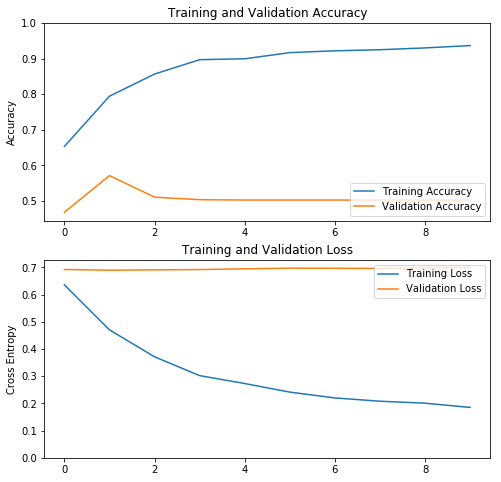

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Fine tuning
In our feature extraction experiment, we were only training a few layers on top of an ResNet50 base model. The weights of the pre-trained network were **not** updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pre-trained model alongside the training of the top-level classifier. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

Note: **this should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable**. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will just forget everything it has learned.

Additionally, **the reasoning behind fine-tuning the top layers** of the pre-trained model rather than all layers of the pre-trained model is the following: in a ConvNet, the higher up a layer is, the more specialized it is. **The first few layers in a ConvNet learned very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly more specific to the dataset that the model was trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.**

### Un-freeze the top layers of the model


All we need to do is unfreeze the `base_model`, and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [16]:
base_model.trainable = True

In [17]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  175


### Compile the model

Compile the model using a much-lower training rate.

In [18]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 19,454,977
Non-trainable params: 4,134,784
_________________________________________________________________


In [20]:
len(model.trainable_variables)

92

### Continue Train the model

If you trained to convergence earlier, this will get you a few percent more accuracy.

In [21]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 145s 2s/step - loss: 0.1467 - acc: 0.9466 - val_loss: 0.6923 - val_acc: 0.5060
Epoch 2/10
62/62 [==============================] - 139s 2s/step - loss: 0.0412 - acc: 0.9929 - val_loss: 0.7012 - val_acc: 0.4940
Epoch 3/10
62/62 [==============================] - 140s 2s/step - loss: 0.0157 - acc: 0.9975 - val_loss: 0.6948 - val_acc: 0.4909
Epoch 4/10
62/62 [==============================] - 139s 2s/step - loss: 0.0054 - acc: 0.9995 - val_loss: 0.6932 - val_acc: 0.5071
Epoch 5/10
62/62 [==============================] - 139s 2s/step - loss: 0.0029 - acc: 0.9995 - val_loss: 0.6963 - val_acc: 0.4859
Epoch 6/10
62/62 [==============================] - 141s 2s/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.6959 - val_acc: 0.4536
Epoch 7/10
62/62 [==============================] - 141s 2s/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.7030 - val_acc: 0.5030
Epoch 8/10
62/62 [==============================] - 139s 2s/step - loss: 0.0021 - a

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy / loss, when fine tuning the last few layers of the MobileNet V2 base model, as well as the classifier on top of it. Note the validation loss much higher than the training loss which means there maybe some overfitting.

**Note**: the training dataset is fairly small, and is similar to the original datasets that MobileNet V2 was trained on, so fine-tuning may result in overfitting.

If you train to convergence (`epochs=50`) the resulting graph should look like this:

![After fine tuning the model nearly reaches 98% accuracy](https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/images/images/fine_tuning.png?raw=1)

In [22]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

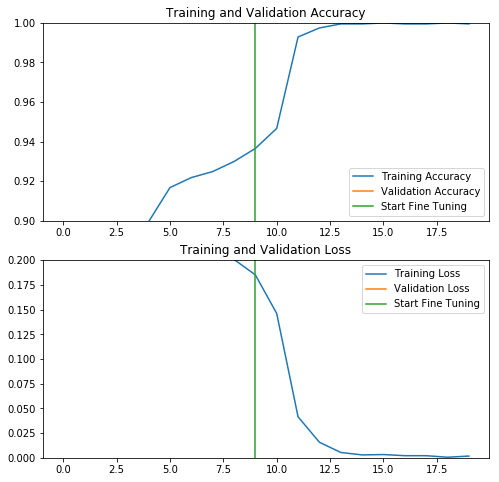

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Key takeaways
In summary here is what we covered in this tutorial on **how to do transfer learning using a pre-trained model** to improve accuracy:
* Using a pre-trained model for **feature extraction** - when working with a small dataset, it is common to leverage the features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier are updated during training.
In this case, the convolutional base extracts all the features associated with each image and we train a classifier that determines, given these set of features to which class it belongs.
* **Fine-tuning** a pre-trained model - to further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, we tune our weights such that we learn highly specified and high level features specific to our dataset. This only make sense **when the training dataset is large and very similar to the original dataset** that the pre-trained model was trained on.
